# Spatial Kernel Density Estimation

In [145]:
import math, os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
from scipy import spatial
from tqdm import tqdm
import sett, kde
import os
os.chdir('/Users/dangchan/Desktop/Github/LocalSecurity_competition')

In [146]:
# Initialize
sett.init()

#read parameters
parameters = {'p1' : 1179.0, 'p3' : 100.0}

sett.p1 = float(parameters['p1'])	# p1 = spatial bandwidth(meter)
sett.p3 = float(parameters['p3'])	# p3 = spatial resolution(meter)

In [160]:
# Load Crime Data
df = gpd.read_file('data/gdf_crime_DJ.gpkg')
df = df.to_crs(epsg=5181) # 좌표계 m단위로 변경
df = df[['RECV_CPLT_DM', 'geometry']]
df.RECV_CPLT_DM = df.RECV_CPLT_DM.dt.to_period('H')
df.RECV_CPLT_DM = df.RECV_CPLT_DM.dt.to_timestamp()

# data에 time index 찾아 넣기(기준시점으로부터 시간)

# X, Y 좌표 추출
df['X'] = df.geometry.x
df['Y'] = df.geometry.y
df = df[['X','Y']]

df = df.drop_duplicates().reset_index(drop=True)

df.head(3) # print example dataset

,X,Y
0,234583.990891,313824.286095
1,236327.937925,316034.747619
2,240145.107404,315535.595667


In [148]:
# 전역변수 설정(global variables)
sett.npts = len(df)
sett.ct1 = 0.5 * math.pi
sett.ct2 = pow(10.0, 5) / (sett.npts * pow(sett.p1, 2))

In [149]:
# 각 벡터 분리
inX = df['X']
inY = df['Y']

inXY = list(zip(inX, inY))

In [150]:
# 격자데이터 로드, 격자화
grid = gpd.read_file('data/CENSUS/grid_DJ_100M.gpkg') # epsg:5181
xyGrid = list(zip(grid.geometry.centroid.x, grid.geometry.centroid.y))

In [151]:
stree = spatial.cKDTree(inXY)
sList = stree.query_ball_point(xyGrid, r=sett.p1)

In [152]:
result = []

for i in range(len(sList)):
    xC, yC = xyGrid[i][0], xyGrid[i][1] # current grid (X,Y : Centroid)
    nList = sList[i]
    density = 0.0 # estimated density
    
    # calculate density
    if nList: # neighbor 존재하면 density 추가
        for k in nList:
            density += kde.densityF(
                inXY[k][0], inXY[k][1], xC, yC)
        
        # save density for point
    result.append([xC, yC, density])

result = pd.DataFrame(result, columns=['X', 'Y', 'density'])
result.to_csv(f'SKDE/result/DJ_100M_sb_{int(sett.p1)}.csv', index=False)
print('SKDE completed!')

SKDE completed!


In [153]:
grid = gpd.read_file('data/CENSUS/grid_DJ_100M.gpkg') # load grid information
result_grid = gpd.GeoDataFrame(result['density'], geometry=gpd.points_from_xy(result.X, result.Y), crs='epsg:5181')

# 격자에 병합
grid = grid.sjoin(result_grid, how='left')

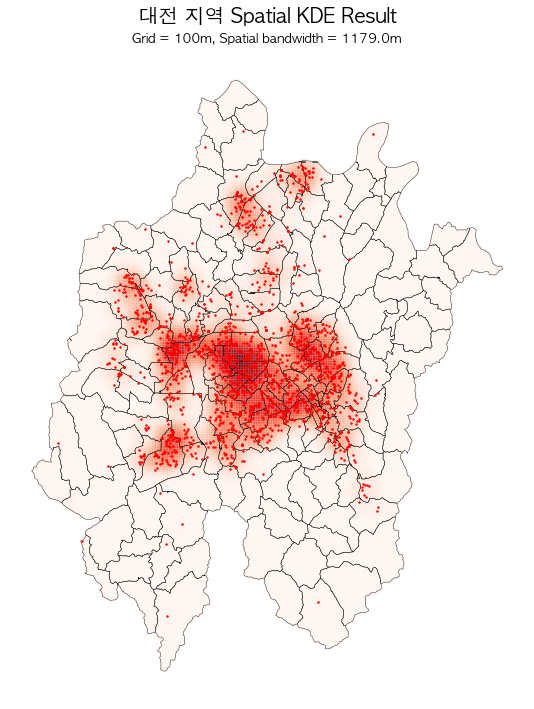

In [161]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

daejeon = gpd.read_file('data/ADM_AREA/대전/LSMD_ADM_SECT_UMD_30.shp', encoding='cp949').to_crs(epsg=5181)
df_crime = gpd.read_file('data/gdf_crime_adm_DJ.gpkg').to_crs(epsg=5181)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
daejeon.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.4)
grid.plot(column = 'density',ax=ax, zorder=1, cmap='Reds')
df_crime.geometry.plot(ax=ax, zorder=3, color='red', markersize=2)

ax.set_axis_off()

plt.suptitle('대전 지역 Spatial KDE Result', fontsize=20)
plt.title(f'Grid = 100m, Spatial bandwidth = {sett.p1}m', fontsize=13)
plt.tight_layout()
plt.savefig(f'SKDE/result/대전 지역 내 보이스피싱 핫스팟(100M)_sb_{int(sett.p1)}.png', facecolor='white')
plt.show()